Training accuracy:  1.0


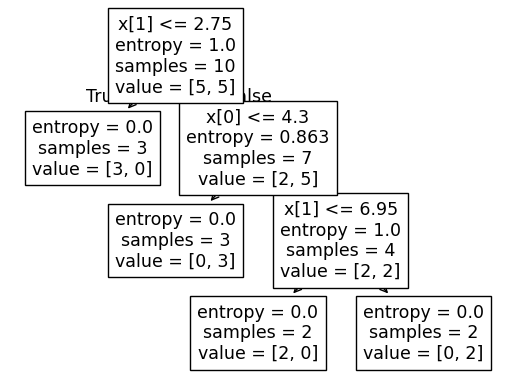

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Sep 12 16:24:42 2020

@author: thomas
"""

from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
    
def reg_tree_classifier():
    
    # CHANGE
    X = np.array([
        [2.1, 1.2],
        [1.9, 1.8],
        [2.2, 1.5],
        [3.5, 4.0],
        [3.8, 4.2],
        [3.2, 3.7],
        [5.0, 7.1],
        [5.5, 6.8],
        [6.0, 7.3],
        [4.8, 6.5]
    ])
    y = np.array([0, 0, 0, 1, 1, 1, 1, 0, 1, 0])
    # pick one : 'gini', 'entropy', 'log_loss'
    criterion = 'gini'
    # choose depth
    max_depth = 4
    # CHANGE
    
    # fit tree
    dtree = tree.DecisionTreeClassifier(criterion, max_depth)
    dtree = dtree.fit(X, y)
    
    # predict
    y_pred = dtree.predict(X)
    # y_testpred = dtree.predict(X_test)
    
    # print accuracies
    print("Training accuracy: ", metrics.accuracy_score(y, y_pred))
    # print("Test accuracy: ", metrics.accuracy_score(y_test, y_testpred))    

    # Plot tree
    tree.plot_tree(dtree)
    plt.show()

reg_tree_classifier()